# Density Estimation via Normalizing Flows

Model the transformation $$f: \mathbf{z}\sim\mathcal{N}(\boldsymbol{0},\mathbf{I})\to\mathbf{z}.$$
With the change-of-variables formula, the network defines an explicit PDF,
$$
p_X(\mathbf{x})=p_Z\bigl(f^{-1}(\mathbf{x})\bigr)\lvert\det\frac{\partial f^{-1}}{\partial \mathbf{x}}\rvert,
$$
and delivers exact likelihood function, enabling tractable training with maximum likelihood estimation.

In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.distributions as D
import matplotlib.pyplot as plt

In [4]:
# Generate 2D data
torch.manual_seed(0)
n = 1000

theta = torch.rand(n) * torch.pi
x1 = torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
x2 = torch.stack([1 - torch.cos(theta), 1 - torch.sin(theta)], dim=1)
data = torch.cat([x1, x2], dim=0)
data += 0.05 * torch.randn_like(data)

In [5]:
# Make Normalizing Flow model
class CouplingLayer(nn.Module):
    def __init__(self, mask):
        super().__init__()
        self.mask = mask
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def inverse(self, y):
        y_m = y * self.mask
        s, t = self.net(y_m).chunk(2, dim=1)
        s = torch.tanh(s)
        x = y_m + (1 - self.mask) * (y - t) * torch.exp(-s)
        log_det = -((1 - self.mask) * s).sum(dim=1)
        return x, log_det

class Flow(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            CouplingLayer(torch.tensor([[1., 0.]])),
            CouplingLayer(torch.tensor([[0., 1.]])),
            CouplingLayer(torch.tensor([[1., 0.]])),
            CouplingLayer(torch.tensor([[0., 1.]])),
        ])
        self.base = D.MultivariateNormal(torch.zeros(2), torch.eye(2))

    def log_prob(self, x):
        log_det = 0
        for layer in reversed(self.layers):
            x, ld = layer.inverse(x)
            log_det += ld
        return self.base.log_prob(x) + log_det

flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

In [6]:
# Train the flow
for epoch in range(1000):
    loss = -flow.log_prob(data).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

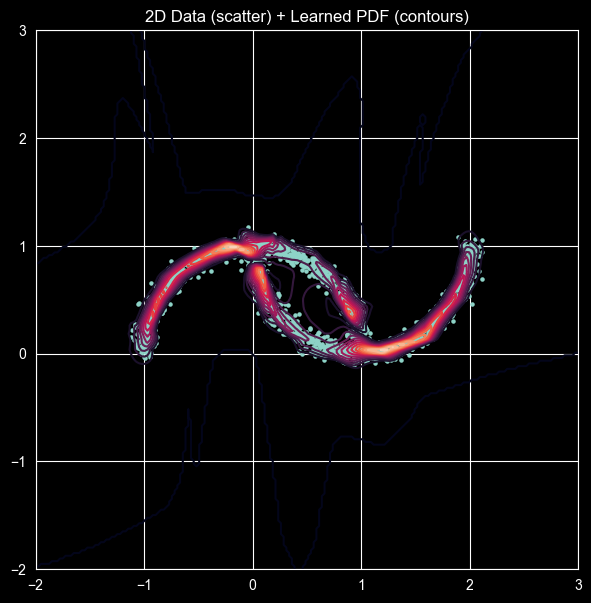

In [13]:
# Evaluate density and plot
x = torch.linspace(-2, 3, 200)
y = torch.linspace(-2, 3, 200)
xx, yy = torch.meshgrid(x, y, indexing="ij")
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

with torch.no_grad():
    density = flow.log_prob(grid).exp().reshape(200, 200)

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], s=5)
plt.contour(xx.numpy(), yy.numpy(), density.numpy(), levels=20)
plt.title("2D Data (scatter) + Learned PDF (contours)")
plt.show()

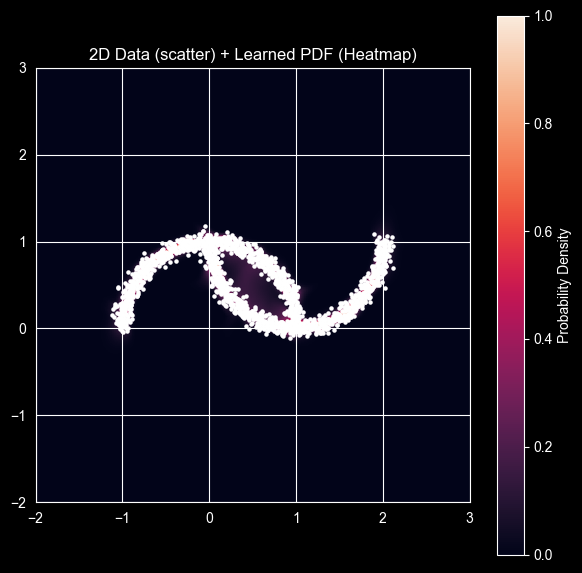

In [15]:
plt.figure(figsize=(7, 7))
plt.imshow(
    density.numpy().T,
    origin="lower",
    extent=[-2, 3, -2, 3],
    aspect="equal"
)
plt.scatter(data[:, 0], data[:, 1], s=5, c="white")
plt.colorbar(label="Probability Density")
plt.title("2D Data (scatter) + Learned PDF (Heatmap)")
plt.show()

# Density Estimation via Mixture Density Network
Model the density as a mixture of Gaussians:
$$
p(x)=\sum_k \pi_k \, \mathcal{N}(x|\mu_k, \Sigma_k)
$$
with diagonal covariance matrices $\Sigma_k$. It is easy to train, one has to set the number of components.

In [9]:
# MDN Model
class MDN(nn.Module):
    def __init__(self, n_components=8):
        super().__init__()
        self.K = n_components

        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.pi = nn.Linear(128, self.K)
        self.mu = nn.Linear(128, 2 * self.K)
        self.log_sigma = nn.Linear(128, 2 * self.K)

    def forward(self, x):
        h = self.net(x)
        pi = torch.softmax(self.pi(h), dim=1)
        mu = self.mu(h).view(-1, self.K, 2)
        sigma = torch.exp(self.log_sigma(h)).view(-1, self.K, 2)
        return pi, mu, sigma

    def log_prob(self, x):
        pi, mu, sigma = self(x)
        x = x.unsqueeze(1)

        normal = D.Normal(mu, sigma)
        log_probs = normal.log_prob(x).sum(dim=2)
        return torch.logsumexp(torch.log(pi) + log_probs, dim=1)

mdn = MDN(n_components=8)
optimizer = torch.optim.Adam(mdn.parameters(), lr=1e-3)

In [10]:
# Train
for epoch in range(2000):
    loss = -mdn.log_prob(data).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

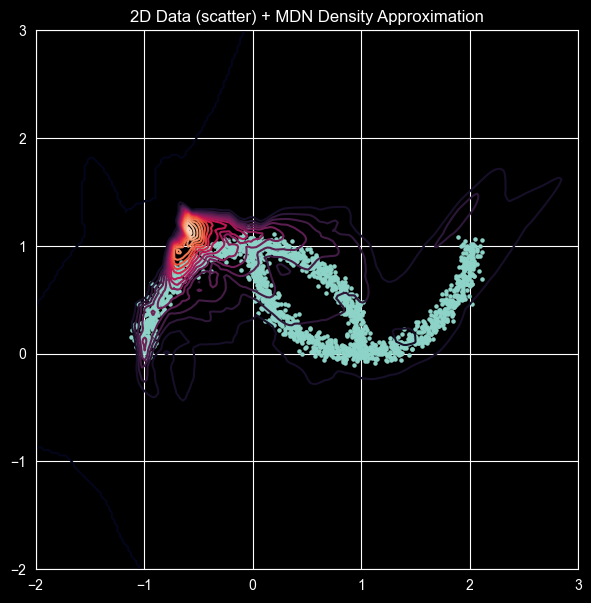

In [11]:
# Evaluate density and plot
x = torch.linspace(-2, 3, 200)
y = torch.linspace(-2, 3, 200)
xx, yy = torch.meshgrid(x, y, indexing="ij")
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

with torch.no_grad():
    density = mdn.log_prob(grid).exp().reshape(200, 200)

plt.figure(figsize=(7, 7))
plt.scatter(data[:, 0], data[:, 1], s=5)
plt.contour(xx.numpy(), yy.numpy(), density.numpy(), levels=20)
plt.title("2D Data (scatter) + MDN Density Approximation")
plt.show()

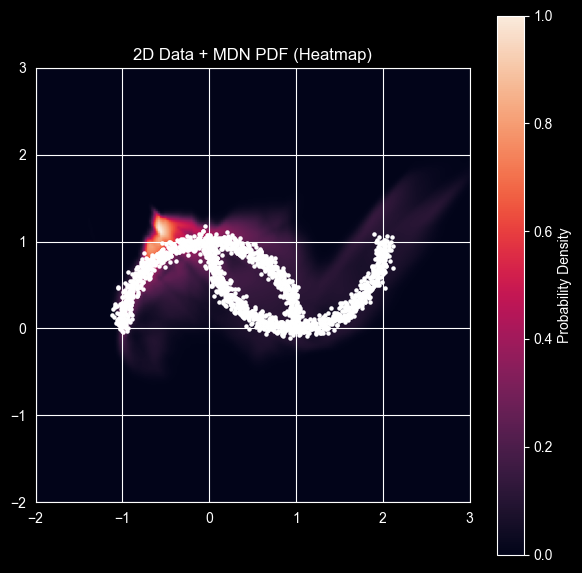

In [12]:
plt.figure(figsize=(7, 7))
plt.imshow(
    density.numpy().T,
    origin="lower",
    extent=[-2, 3, -2, 3],
    aspect="equal"
)
plt.scatter(data[:, 0], data[:, 1], s=5, c="white")
plt.colorbar(label="Probability Density")
plt.title("2D Data + MDN PDF (Heatmap)")
plt.show()

# General case of conditional density estimation
Goes via the Cholesky decomposition of the covariance matrix
$$
\boldsymbol{\Sigma} = \mathbf{L} \mathbf{L}^\mathsf{T},
$$
where $\mathbf{L}$ is a lower-triangular matrix with positive diagonal elements.